# Multi-Degree Drug Interaction Kinetics Test

**Purpose**: Test kinetic behavior of multi-degree drug interaction network using DegreeInteractionSpec

**System**: D → {R1_i} → {I1_i} → O central pathway with higher-degree cascades providing feedback

**Degrees**: [1, 2, 4] where:
  - Degree 1: 1 cascade (R1_1 → I1_1 → O) - central pathway
  - Degree 2: 2 cascades (R2_1 → I2_1, R2_2 → I2_2) - feedback to degree 1
  - Degree 3: 4 cascades (R3_1 → I3_1, ..., R3_4 → I3_4) - feedback to degree 2

**Feedback Regulation Algorithm**:
  - **Mandatory downward regulations**: Each I species in degree n>1 regulates random R/I species in degree n-1
  - **Density-controlled upward regulations**: feedback_density controls proportion of cascades with upward feedback
  - **Adjacent degrees only**: All feedback connects only between degrees n and n-1
  - **Trimming**: When density < 1, upward regulations trimmed from outermost degrees first

**Focus**: Test functionality of multi-degree network, feedback regulations, and drug response

## Initial Setup

Simple path configuration for proper module imports

In [65]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


## Imports

Minimal imports focusing on DegreeInteractionSpec

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from models.Specs.DegreeInteractionSpec import DegreeInteractionSpec
from models.Specs.Drug import Drug
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

print("Imports complete")

Imports complete


## 1. Create Multi-Degree Network

Create the network with degree_cascades=[1, 2, 4]
This creates a total of 1+2+4 = 7 cascades × 2 species each + O = 15 species

In [67]:
# Initialize degree interaction specification
degree_spec = DegreeInteractionSpec(degree_cascades=[1])

# Generate complete specifications with moderate feedback density
degree_spec.generate_specifications(
    random_seed=42,
    feedback_density=1  # 30% of cascades get upward feedback (mandatory downward always present)
)

print(f"Network created with {len(degree_spec.species_list)} species")
print(f"Degrees: {list(degree_spec.degree_species.keys())}")

# Show species by degree
for degree in [1, 2, 3]:
    species = degree_spec.get_species_by_degree(degree, 'all')
    print(f"Degree {degree} species ({len(species)}): {species[:4]}..." if len(species) > 4 else f"Degree {degree} species: {species}")
    
all_regulations = degree_spec.regulations
print(f"Total regulations: {len(all_regulations)}")

# print regulations one by one 
for reg in all_regulations:
    print(reg)

Network created with 3 species
Degrees: [1]
Degree 1 species: ['R1_1', 'I1_1']
Degree 2 species: []
Degree 3 species: []
Total regulations: 2
Regulation(from_specie='R1_1', to_specie='I1_1', reg_type='up')
Regulation(from_specie='I1_1', to_specie='O', reg_type='up')


## 2. Add Drug Targeting Degree 1 R Species

Drug D will target R1_1 (the only degree 1 R species) with down-regulation

In [68]:
# Create drug D that down-regulates R1_1
drug_d = Drug(
    name="D",
    start_time=5000.0,     # Drug applied at time 500
    default_value=1000.0,    # Drug concentration
    regulation=["R1_1"],  # Regulates R1_1 (degree 1, cascade 1)
    regulation_type=["down"]  # Down-regulation decreases activation
)

# Add drug to model
degree_spec.add_drug(drug_d)
print(f"Drug added: {drug_d.name} targeting {drug_d.regulation}")

# Verify drug validation works
print(f"Drug species list: {[d.name for d in degree_spec.drugs]}")
print(f"Total regulations: {len(degree_spec.regulations)}")

Drug added: D targeting ['R1_1']
Drug species list: ['D']
Total regulations: 3


## 3. Generate Model with Controlled Parameters

Create the actual model with parameter ranges for testing functionality

In [69]:
# Generate the model
model = degree_spec.generate_network(
    network_name="MultiDegree_Kinetics",
    mean_range_species=(50, 150),      # Initial concentrations
    rangeScale_params=(0.8, 1.2),      # ±20% variation
    rangeMultiplier_params=(0.9, 1.1), # Small additional variation
    random_seed=42,
    receptor_basal_activation=False     # Receptors have basal activation
)

print(f"Model created: {model.name}")
print(f"Total reactions: {len(model.reactions)}")
print(f"Total states: {len(model.states)}")
print(f"Total parameters: {len(model.parameters)}")

# Show a few key states
key_states = ['R1_1', 'I1_1', 'R2_1', 'I2_1', 'R3_1', 'I3_1', 'O']
available_states = [s for s in key_states if s in model.states]
print(f"Key states available: {available_states}")

Model created: MultiDegree_Kinetics
Total reactions: 6
Total states: 6
Total parameters: 13
Key states available: ['R1_1', 'I1_1', 'O']


In [70]:
print(model.get_antimony_model())

model MultiDegree_Kinetics

J0: R1_1a -> R1_1; Vmax_J0*R1_1a/(Km_J0 + R1_1a)
J1: R1_1 -> R1_1a; Kc_J1*R1_1/(Km_J1 + R1_1)/(1 + D/Ki0_J1)
J2: I1_1a -> I1_1; Vmax_J2*I1_1a/(Km_J2 + I1_1a)
J3: I1_1 -> I1_1a; (Kc0_J3*R1_1a)*I1_1/(Km_J3 + I1_1)
J4: Oa -> O; Vmax_J4*Oa/(Km_J4 + Oa)
J5: O -> Oa; (Kc0_J5*I1_1a)*O/(Km_J5 + O)

# State variables in the system
R1_1a=0
R1_1=123
I1_1a=0
I1_1=126
Oa=0
O=94

# Parameters in the system
Km_J0=103.15377754210397
Vmax_J0=9.548267987927224
Km_J1=109.60185376826276
Kc_J1=1.1885748349506415
Ki0_J1=0.009173539435507999
Km_J2=90.06213568148742
Vmax_J2=8.796205717533443
Km_J3=120.4390747264928
Kc0_J3=0.11163263871158213
Km_J4=104.34805368495678
Vmax_J4=8.966636948705082
Km_J5=110.70017850434297
Kc0_J5=0.10304720449787655

# Other variables in the system
D := piecewise(0, time < 5000.0, 1000.0)


end


## 4. Swapping parameters for Testing

In [71]:
from models.utils.parameter_mapper import get_parameters_for_state

state_variables = model.get_state_variables()

# filter all state variables with 'a' at the end
state_variables = {k: v for k, v in state_variables.items() if k.endswith('a')}

for state in state_variables.keys():
    params = get_parameters_for_state(model, state)
    forward_parameters = params['as_product']
    backward_parameters = params['as_reactant']
    
    # extract 'km' from the backward parameters list 
    km_b = [p for p in backward_parameters if p.startswith('Km')]
    
    # extract 'km' and also 'ki' from the forward parameters list
    km_f = [p for p in forward_parameters if p.startswith('Km')]
    ki_f = [p for p in forward_parameters if p.startswith('Ki')]
    km_f = km_f + ki_f
    
    # extract 'vmax' and 'kc' from the forward parameters list
    vmax_f = [p for p in forward_parameters if p.startswith('Vmax')]
    kc_f = [p for p in forward_parameters if p.startswith('Kc')]
    vmax_f = vmax_f + kc_f
    
    # extract 'vmax' from the backward parameters list
    vmax_b = [p for p in backward_parameters if p.startswith('Vmax')]
    print(f"State: {state}, Forward params: {forward_parameters}, Backward params: {backward_parameters}")
    print(f"   km forward: {km_f}, km backward: {km_b}")
    print(f"   vmax forward: {vmax_f}, vmax backward: {vmax_b}")

State: R1_1a, Forward params: ['Km_J1', 'Kc_J1', 'Ki0_J1'], Backward params: ['Km_J0', 'Vmax_J0']
   km forward: ['Km_J1', 'Ki0_J1'], km backward: ['Km_J0']
   vmax forward: ['Kc_J1'], vmax backward: ['Vmax_J0']
State: I1_1a, Forward params: ['Km_J3', 'Kc0_J3'], Backward params: ['Km_J2', 'Vmax_J2']
   km forward: ['Km_J3'], km backward: ['Km_J2']
   vmax forward: ['Kc0_J3'], vmax backward: ['Vmax_J2']
State: Oa, Forward params: ['Km_J5', 'Kc0_J5'], Backward params: ['Km_J4', 'Vmax_J4']
   km forward: ['Km_J5'], km backward: ['Km_J4']
   vmax forward: ['Kc0_J5'], vmax backward: ['Vmax_J4']


In [72]:
model.get_state_variables()

{'R1_1a': 0,
 'R1_1': np.int64(123),
 'I1_1a': 0,
 'I1_1': np.int64(126),
 'Oa': 0,
 'O': np.int64(94)}

In [80]:
from models.utils.kinetic_tuner import KineticParameterTuner

tuner = KineticParameterTuner(model, random_seed=42)

updated_params = tuner.generate_parameters(active_percentage_range=(0.3, 0.7))

print("Tuned Parameters:")
for param, value in updated_params.items():
    print(f"  {param}: {value:.3f}")

Tuned Parameters:
  Vmax_J0: 5.436
  Kc_J1: 8.487
  Km_J0: 615.000
  Ki0_J1: 100.000
  Km_J1: 55.909
  Vmax_J2: 6.033
  Kc0_J3: 5.471
  Km_J2: 630.000
  Km_J3: 630.000
  Vmax_J4: 5.474
  Kc0_J5: 9.878
  Km_J4: 470.000
  Km_J5: 470.000


In [81]:
# Apply tuned parameters to the model

for param in updated_params:
    # param is a dict key, so we need to get its value
    print(f"Setting parameter {param} to {updated_params[param]:.3f}")
    model.set_parameter(param, updated_params[param])

# model.set_parameter("Ki0_J1", 0.01)
    
print(model.get_antimony_model())

Setting parameter Vmax_J0 to 5.436
Setting parameter Kc_J1 to 8.487
Setting parameter Km_J0 to 615.000
Setting parameter Ki0_J1 to 100.000
Setting parameter Km_J1 to 55.909
Setting parameter Vmax_J2 to 6.033
Setting parameter Kc0_J3 to 5.471
Setting parameter Km_J2 to 630.000
Setting parameter Km_J3 to 630.000
Setting parameter Vmax_J4 to 5.474
Setting parameter Kc0_J5 to 9.878
Setting parameter Km_J4 to 470.000
Setting parameter Km_J5 to 470.000
model MultiDegree_Kinetics

J0: R1_1a -> R1_1; Vmax_J0*R1_1a/(Km_J0 + R1_1a)
J1: R1_1 -> R1_1a; Kc_J1*R1_1/(Km_J1 + R1_1)/(1 + D/Ki0_J1)
J2: I1_1a -> I1_1; Vmax_J2*I1_1a/(Km_J2 + I1_1a)
J3: I1_1 -> I1_1a; (Kc0_J3*R1_1a)*I1_1/(Km_J3 + I1_1)
J4: Oa -> O; Vmax_J4*Oa/(Km_J4 + Oa)
J5: O -> Oa; (Kc0_J5*I1_1a)*O/(Km_J5 + O)

# State variables in the system
R1_1a=0
R1_1=123
I1_1a=0
I1_1=126
Oa=0
O=94

# Parameters in the system
Km_J0=615.0
Vmax_J0=5.435543235343639
Km_J1=55.90909090909091
Kc_J1=8.486840145296819
Ki0_J1=100.0
Km_J2=630.0
Vmax_J2=6.0334

In [82]:
target_concentrations = tuner.get_target_concentrations()
for t in target_concentrations.items():
    print(f"Target concentration for {t[0]}: {t[1]:.3f}")

Target concentration for R1_1a: 74.979
Target concentration for I1_1a: 59.919
Target concentration for Oa: 60.483


## 5. Test Basic Functionality with Simulation

Simulate the multi-degree network to verify it works correctly

In [83]:
# Create solver
solver = RoadrunnerSolver()

# Compile model and simulate
try:
    solver.compile(model.get_sbml_model())
    result = solver.simulate(start=0, stop=10000, step=101)  # 0-1000 with 101 points
    
    print("Simulation successful!")
    print(f"Timepoints: {len(result['time'])}")
    print(f"Columns: {list(result.columns)[:10]}...")
    
except Exception as e:
    print(f"Simulation error: {e}")
    # Fallback: try to get antimony model for debugging
    print("\nDebug: Antimony model (first 20 lines):")
    antimony_model = model.get_antimony_model()
    print("\n".join(antimony_model.split("\n")[:20]))

Simulation successful!
Timepoints: 101
Columns: ['time', 'R1_1a', 'R1_1', 'I1_1a', 'I1_1', 'Oa', 'O']...


In [84]:
# Cross-check if target concentrations were reached at the last timepoint
print("Target Concentration Achievement Analysis")
print("=" * 60)

last_timepoint = result.iloc[-1]  # Get last row of simulation results

for species, target in target_concentrations.items():
    if species in result.columns:
        final_value = last_timepoint[species]
        difference = final_value - target
        percent_diff = (difference / target) * 100 if target != 0 else 0
        
        status = "✓ Reached" if abs(percent_diff) < 5 else "✗ Not reached"
        
        print(f"{species:8} | Target: {target:8.2f} | Final: {final_value:8.2f} | Diff: {difference:7.2f} ({percent_diff:6.2f}%) | {status}")

Target Concentration Achievement Analysis
R1_1a    | Target:    74.98 | Final:    52.77 | Diff:  -22.21 (-29.62%) | ✗ Not reached
I1_1a    | Target:    59.92 | Final:   123.83 | Diff:   63.91 (106.66%) | ✗ Not reached
Oa       | Target:    60.48 | Final:    93.65 | Diff:   33.17 ( 54.84%) | ✗ Not reached


## 6. Visualize Key Species Across Degrees

Plot representative species from each degree to show signal propagation

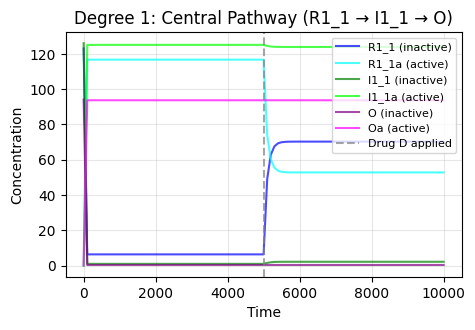

In [85]:
if 'result' in locals():
    plt.figure(figsize=(9, 6))
    
    # Subplot 1: Degree 1 (central pathway)
    plt.subplot(2, 2, 1)
    plt.plot(result['time'], result['R1_1'], label='R1_1 (inactive)', color='blue', alpha=0.7)
    plt.plot(result['time'], result['R1_1a'], label='R1_1a (active)', color='cyan', alpha=0.7)
    plt.plot(result['time'], result['I1_1'], label='I1_1 (inactive)', color='green', alpha=0.7)
    plt.plot(result['time'], result['I1_1a'], label='I1_1a (active)', color='lime', alpha=0.7)
    plt.plot(result['time'], result['O'], label='O (inactive)', color='purple', alpha=0.7)
    plt.plot(result['time'], result['Oa'], label='Oa (active)', color='magenta', alpha=0.7)
    plt.axvline(x=5000, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Degree 1: Central Pathway (R1_1 → I1_1 → O)')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Degree 2 (feedback to degree 1)
    # plt.subplot(2, 2, 2)
    # plt.plot(result['time'], result['R2_1'], label='R2_1 (inactive)', color='blue', alpha=0.7)
    # plt.plot(result['time'], result['R2_1a'], label='R2_1a (active)', color='cyan', alpha=0.7)
    # plt.plot(result['time'], result['I2_1'], label='I2_1 (inactive)', color='green', alpha=0.7)
    # plt.plot(result['time'], result['I2_1a'], label='I2_1a (active)', color='lime', alpha=0.7)
    # plt.axvline(x=5000, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    # plt.xlabel('Time')
    # plt.ylabel('Concentration')
    # plt.title('Degree 2: Feedback Cascade 1')
    # plt.legend(loc='upper right', fontsize=8)
    # plt.grid(True, alpha=0.3)
    
    # Subplot 3: Degree 3 (feedback to degree 2)
    # plt.subplot(2, 2, 3)
    # plt.plot(result['time'], result['R3_1'], label='R3_1 (inactive)', color='blue', alpha=0.7)
    # plt.plot(result['time'], result['R3_1a'], label='R3_1a (active)', color='cyan', alpha=0.7)
    # plt.plot(result['time'], result['I3_1'], label='I3_1 (inactive)', color='green', alpha=0.7)
    # plt.plot(result['time'], result['I3_1a'], label='I3_1a (active)', color='lime', alpha=0.7)
    # plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    # plt.xlabel('Time')
    # plt.ylabel('Concentration')
    # plt.title('Degree 3: Feedback Cascade 1')
    # plt.legend(loc='upper right', fontsize=8)
    # plt.grid(True, alpha=0.3)
    
    # Subplot 4: Drug effect summary
    # plt.subplot(2, 2, 4)
    # active_species = ['R1_1a', 'I1_1a', 'Oa', 'R2_1a', 'I2_1a', 'R3_1a', 'I3_1a']
    # colors = plt.cm.Set3(np.linspace(0, 1, len(active_species)))
    
    # for i, species in enumerate(active_species):
    #     if species in result.columns:
    #         plt.plot(result['time'], result[species], label=species, color=colors[i], alpha=0.8)
    
    # plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    # plt.xlabel('Time')
    # plt.ylabel('Active Concentration')
    # plt.title('Active Species Across All Degrees')
    # plt.legend(loc='upper right', fontsize=7)
    # plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()